In [1]:
from src.utils.myOptimization import (
    solveGroupProblem, closed_form_group_alpha, AlphaFairnesstorch,
    solveIndProblem, solve_closed_form, solve_coupled_group_alpha, compute_coupled_group_obj
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_fairness_grad,mean_abs_dev, compute_group_accuracy_parity

import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd

from src.utils.features import get_all_features
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Define Alpha & Q

In [2]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "beta": 2.5,
    "Q": 2000,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "w") as f:
    json.dump(params, f, indent=4)

import json

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "r") as f:
    params = json.load(f)

n_sample = params["n_sample"]
alpha    = params["alpha"]
beta     = params["beta"]
Q        = params["Q"]
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]


In [3]:
df = pd.read_csv('/Users/dennis/Downloads/2024-fall/research/Fairness-Decision-Focused-Loss/Organized-FDFL/src/data/data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values) * 10
cost = np.maximum(cost, 0.1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values) * 100
true_benefit = np.maximum(true_benefit, 0.1) 

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

## Prediction Model

In [4]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [5]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)


## Training Function

In [94]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time # Added for timing

# ------------------------------------------------------------------
#  Fairness helpers (assuming these are defined elsewhere in your code)
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)
# atkinson_loss(...)
# mean_abs_dev(...)
# solve_coupled_group_alpha(...)
# compute_coupled_group_obj(...)
# solve_closed_form(...)
# AlphaFairnesstorch(...)
# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, beta, Q,
        lambda_fair=0.0, fairness_type="None", group=True,
        num_epochs=30, lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cpu")):
    """
    Train a fairness–aware predictor and log train-loss, test-MSE,
    test-normalised-regret, test-fairness, per-group MSE, per-group
    decision objectives, and total training time.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test  = torch.tensor(X_test, dtype=torch.float32)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32)
        y_test  = torch.tensor(y_test, dtype=torch.float32)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32)
        race_test  = torch.tensor(race_test, dtype=torch.float32)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    optim  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []
    # New logs for group-wise data
    unique_groups = torch.unique(race_test).cpu().numpy()
    per_group_mse_log = {g: [] for g in unique_groups}
    # For group=True, this will store the mean utility per group
    per_group_decision_obj_log = {g: [] for g in unique_groups}


    # -------------------------- training loop ----------------------
    start_time = time.time() # Start timer
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = atkinson_loss(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            elif fairness_type == "mad":
                fair_pen = mean_abs_dev(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            else:
                fair_pen = torch.tensor(0.0, device=device)

            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        # (1) NEW: Per-group MSE calculation
        for g in unique_groups:
            mask = race_test == g
            group_mse = ((pred_test[mask] - y_test[mask]).pow(2)).mean().item()
            per_group_mse_log[g].append(group_mse)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1e-1)

        # regret on test set
        race_np    = race_test.numpy()
        if group:
            pred_b_np = pred_test.numpy().reshape(-1)
            y_test_np = y_test.numpy().reshape(-1) if isinstance(y_test, torch.Tensor) else np.array(y_test).reshape(-1)
            cost_test_np = cost_test.numpy().reshape(-1) if isinstance(cost_test, torch.Tensor) else np.array(cost_test).reshape(-1)
            race_np = race_test.numpy().reshape(-1) if isinstance(race_test, torch.Tensor) else np.array(race_test).reshape(-1)

            sol_pred = solve_coupled_group_alpha(pred_b_np, cost_test_np, race_np, alpha=alpha, Q=Q, beta=beta)
            sol_true = solve_coupled_group_alpha(y_test_np, cost_test_np, race_np, alpha=alpha, Q=Q, beta=beta)
            true_obj = compute_coupled_group_obj(sol_true, y_test_np, race_np, alpha=alpha, beta=beta)
            pred_obj = compute_coupled_group_obj(sol_pred, y_test_np, race_np, alpha=alpha, beta=beta)

            # (2) NEW: Per-group decision objective (mean utility)
            util_pred = y_test_np * sol_pred # Utility = benefit * decision
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean()
                per_group_decision_obj_log[g].append(group_decision_obj)

        else: # individual fairness case
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()
            ones_array = np.ones_like(b_pred)

            # solve the individual problem
            sol_pred_i, _ = solve_closed_form(ones_array ,b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solve_closed_form(ones_array,b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()

            # (2) NEW: Per-group decision objective (mean utility)
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean().item()
                per_group_decision_obj_log[g].append(group_decision_obj)

        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)

        # fairness on test set
        if fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = atkinson_loss(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        elif fairness_type == "mad":
            fair_val = mean_abs_dev(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        else: # when no fairness
            fair_val = torch.tensor(0.0, device=device)
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            # print(msg)

    end_time = time.time() # End timer
    training_time = end_time - start_time # (3) NEW: Calculate total training time

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log,
                   "training_time": training_time,
                   "per_group_mse": per_group_mse_log,
                   "per_group_decision_objective": per_group_decision_obj_log
                   }

# Training Group (Pred+Opt)

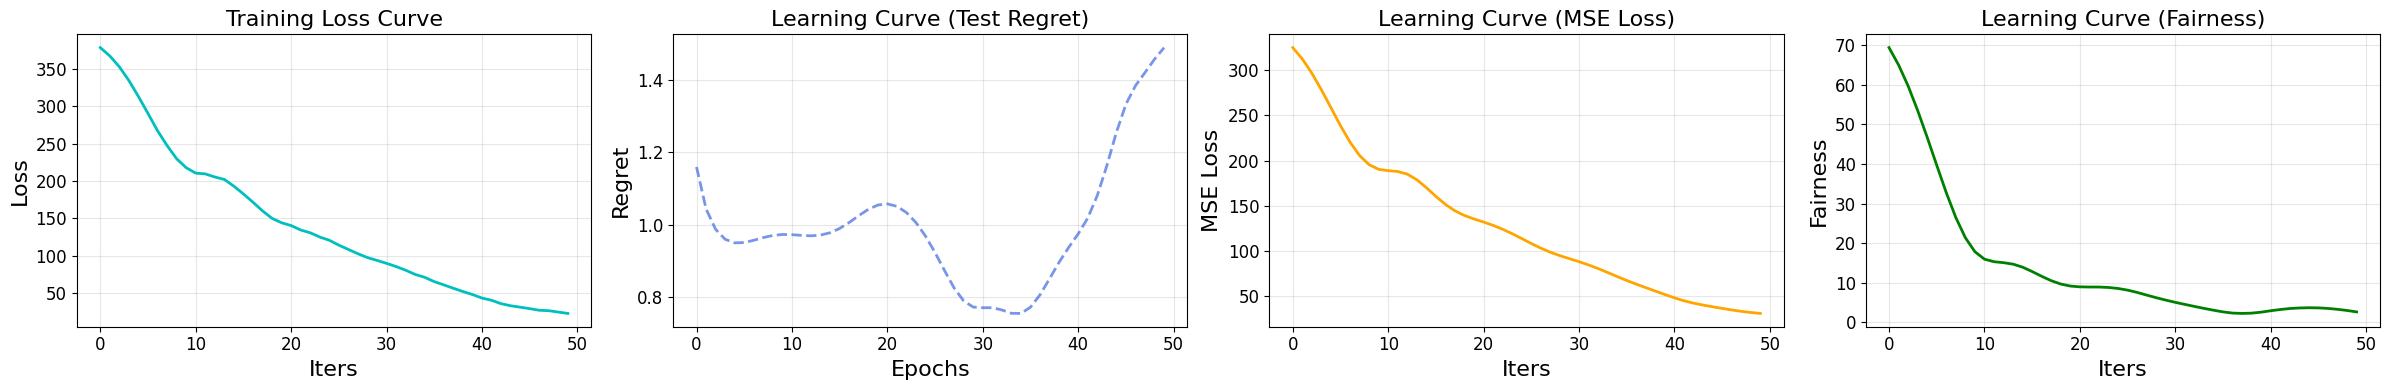

In [95]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, beta=beta, Q=Q,
    lambda_fair=0,
    fairness_type="mad", 
    num_epochs=epochs, lr=lr,
    group=True
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


In [96]:
logs

{'loss_log': [378.64935302734375,
  367.49786376953125,
  352.91864013671875,
  334.4897155761719,
  313.19903564453125,
  290.3995056152344,
  267.33685302734375,
  247.45516967773438,
  229.83889770507812,
  217.81585693359375,
  210.56080627441406,
  209.54196166992188,
  205.37657165527344,
  202.0863800048828,
  193.0697021484375,
  182.65586853027344,
  171.6014862060547,
  159.9955596923828,
  149.971923828125,
  144.0794219970703,
  140.31716918945312,
  134.42152404785156,
  130.6516571044922,
  124.94573974609375,
  120.66073608398438,
  114.09034729003906,
  108.29847717285156,
  102.62245178222656,
  97.39775085449219,
  93.66365814208984,
  89.7088851928711,
  85.39344024658203,
  80.5284423828125,
  74.85304260253906,
  70.9874496459961,
  65.23470306396484,
  60.84317398071289,
  56.3424186706543,
  51.96989440917969,
  47.928348541259766,
  43.2140007019043,
  40.272178649902344,
  35.711891174316406,
  32.892948150634766,
  31.023406982421875,
  29.064844131469727,
  2

# Evaluation

In [97]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

# Assume train_fair_model_logged and FairRiskPredictor are defined as before.
# Assume X_train, y_train, race_train, X_test, y_test, race_test, cost_test, Q are loaded.

def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, beta, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        n_trials=10, base_seed=2025, group=True,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` and average all results,
    including detailed group-wise metrics.
    """
    # Use a single defaultdict to store lists of final metrics from each trial
    trial_logs = defaultdict(list)

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f"\n--- Trial {t+1}/{n_trials} (Seed: {seed}) ---")

        _, logs = train_fair_model_logged(
            X_train, y_train, race_train, X_test, y_test, race_test, cost_test,
            model_class, input_dim, alpha, beta, Q,
            lambda_fair=lambda_fair, fairness_type=fairness_type,
            num_epochs=num_epochs, lr=lr, batch_size=batch_size,
            dropout_rate=dropout_rate, weight_decay=weight_decay,
            device=device, group=group
        )

        # --- Collect final metrics from the logs of the current trial ---
        # Scalar metrics
        trial_logs['regret'].append(logs['regret_log'][-1])
        trial_logs['mse'].append(logs['mse_log'][-1])
        trial_logs['fairness'].append(logs['fairness_log'][-1])
        trial_logs['training_time'].append(logs['training_time'])

        # Group-wise MSE
        for g_id, g_log in logs['per_group_mse'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_mse'].append(g_log[-1])

        # Group-wise decision objective (only if group=True)
        for g_id, g_log in logs['per_group_decision_objective'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_decision_obj'].append(g_log[-1])


    # --- Averaging and Reporting ---
    print("\n" + "="*60)
    print("      AVERAGED RESULTS ACROSS ALL TRIALS")
    print("="*60)

    avg_results = {}
    print("\n--- Overall Performance ---")
    overall_keys = ['regret', 'mse', 'fairness', 'training_time']
    for key in overall_keys:
        values = trial_logs[key]
        mean_k, std_k = (np.mean(values), np.std(values)) if values else (np.nan, np.nan)
        avg_results[key] = mean_k
        avg_results[f"{key}_std"] = std_k
        print(f"[{key.upper():>15s}] final mean = {mean_k:.4f}  |  std = {std_k:.4f}")

    group_keys = sorted([k for k in trial_logs.keys() if k.startswith('G')])
    if group_keys:
        print("\n--- Group-wise Performance ---")
        for key in group_keys:
            values = trial_logs[key]
            mean_k, std_k = (np.mean(values), np.std(values)) if values else (np.nan, np.nan)
            avg_results[key] = mean_k
            avg_results[f"{key}_std"] = std_k
            print(f"[{key.upper():>15s}] final mean = {mean_k:.4f}  |  std = {std_k:.4f}")

    return avg_results



In [93]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, beta=beta, Q=Q,
    lambda_fair=lambdas,
    fairness_type="mad",
    num_epochs=30,
    lr=lr,
    n_trials=2,
    group=False
)

# # Visualise the averaged learning curves
# visLearningCurve(avg_logs["loss_log"],
#                  avg_logs["regret_log"],
#                  avg_logs["mse_log"],
#                  avg_logs["fairness_log"])



--- Trial 1/2 (Seed: 2025) ---

--- Trial 2/2 (Seed: 2026) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 1.0201  |  std = 0.0230
[            MSE] final mean = 111.6871  |  std = 3.5792
[       FAIRNESS] final mean = 93.0526  |  std = 1.0871
[  TRAINING_TIME] final mean = 0.9853  |  std = 0.0112

--- Group-wise Performance ---
[         G0_MSE] final mean = 110.5209  |  std = 3.5920
[         G1_MSE] final mean = 120.7150  |  std = 3.4801


In [111]:
# =================================================================
#  MAIN EXPERIMENT LOOP
# =================================================================
# Dummy values for demonstration
epochs = 50
lr = 0.01
Q = 1000

# --- Define hyperparameter grid ---
alphas = [0.5, 1.5, 2]
fairness_lambdas = [0, 1.0]
group_settings = [True, False]
fairness_types = ['mad', 'atkinson']
results_list = []

for group in group_settings:
    for lam in fairness_lambdas:
        for fairness in fairness_types:

            for alpha in alphas:
                # Set beta = alpha consistently
                beta = alpha

                run_params = {
                    'Group':    group,
                    'Alpha':    alpha,
                    'Beta':     beta,
                    'Lambda':   lam,
                    'Fairness': fairness
                }
                print("\n" + "="*70)
                print(f"RUNNING EXPERIMENT: {run_params}")
                print("="*70)

                # Call the revised multi-trial function
                avg_logs = train_many_trials(
                    X_train, y_train, race_train,
                    X_test, y_test, race_test,
                    cost_test,
                    model_class=FairRiskPredictor,
                    input_dim=X_train.shape[1],
                    alpha=alpha, beta=beta, Q=Q,
                    lambda_fair=lam,
                    fairness_type=fairness,
                    num_epochs=epochs,
                    lr=lr,
                    n_trials=5, # Using 5 for a quick run
                    group=group
                )

                # --- Combine parameters and results into a single flat dictionary ---
                final_run_results = run_params.copy()
                final_run_results.update(avg_logs)
                results_list.append(final_run_results)

# --- Present Final Results in a DataFrame ---
results_df = pd.DataFrame(results_list)

# Organize columns for better readability
main_cols = ['Group', 'Alpha', 'Lambda', 'Fairness', 'regret', 'mse', 'fairness', 'training_time']
# Add std deviations and group metrics automatically
other_cols = sorted([col for col in results_df.columns if col not in main_cols])
results_df = results_df[main_cols + other_cols]

print("\n\n" + "="*80)
print("             GRID SEARCH COMPLETE")
print("="*80)
print("\n--- Experiment Results Summary (Pandas DataFrame) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 180):
    print(results_df)

# Save to CSV
results_df.to_csv("experiment_results_summary_with_groups.csv", index=False)


RUNNING EXPERIMENT: {'Group': True, 'Alpha': 0.5, 'Beta': 0.5, 'Lambda': 0, 'Fairness': 'mad'}

--- Trial 1/5 (Seed: 2025) ---

--- Trial 2/5 (Seed: 2026) ---

--- Trial 3/5 (Seed: 2027) ---

--- Trial 4/5 (Seed: 2028) ---

--- Trial 5/5 (Seed: 2029) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.0410  |  std = 0.0022
[            MSE] final mean = 31.0032  |  std = 1.2532
[       FAIRNESS] final mean = 1.6455  |  std = 0.3077
[  TRAINING_TIME] final mean = 1.9647  |  std = 0.0853

--- Group-wise Performance ---
[G0_DECISION_OBJ] final mean = 17.1363  |  std = 0.5191
[         G0_MSE] final mean = 30.6267  |  std = 1.2146
[G1_DECISION_OBJ] final mean = 93.9547  |  std = 2.2631
[         G1_MSE] final mean = 33.9177  |  std = 1.6257

RUNNING EXPERIMENT: {'Group': True, 'Alpha': 1.5, 'Beta': 1.5, 'Lambda': 0, 'Fairness': 'mad'}

--- Trial 1/5 (Seed: 2025) ---

--- Trial 2/5 (Seed: 2026) ---

--- Trial 3/5 (Seed: 2027) ---

---

In [109]:
results_df[main_cols]

,Group,Alpha,Lambda,Fairness,regret,mse,fairness,training_time
0,True,0.5,0.0,mad,0.041049,31.003152,1.645545,1.757330
1,True,1.5,0.0,mad,0.092681,31.003152,1.645545,1.736354
2,True,2.0,0.0,mad,4.680760,31.003152,1.645545,1.742992
3,True,0.5,1.0,mad,0.041652,32.325852,2.613193,1.701456
4,True,1.5,1.0,mad,0.080029,32.325852,2.613193,1.733575
5,True,2.0,1.0,mad,2.341247,32.325852,2.613193,1.734358
6,True,0.5,1.0,atkinson,0.041049,31.002665,0.000280,1.692721
7,True,1.5,1.0,atkinson,0.092856,31.002665,0.000280,1.698590
8,True,2.0,1.0,atkinson,4.746035,31.002665,0.000280,1.750477
9,False,0.5,0.0,mad,0.084510,31.003152,40.247185,1.701257


In [110]:
results_df[other_cols]

,Beta,G0_decision_obj,G0_decision_obj_std,G0_mse,G0_mse_std,G1_decision_obj,G1_decision_obj_std,G1_mse,G1_mse_std,fairness_std,mse_std,regret_std,training_time_std
0,0.5,17.136275,0.519140,30.626651,1.214638,93.954746,2.263086,33.917741,1.625727,0.307683,1.253219,0.002219,0.031419
1,1.5,5.499357,1.154546,30.626651,1.214638,13.702216,0.867592,33.917741,1.625727,0.307683,1.253219,0.027641,0.074766
2,2.0,6.754837,1.839890,30.626651,1.214638,2.844876,1.343215,33.917741,1.625727,0.307683,1.253219,5.572814,0.068365
3,0.5,16.773503,0.455669,31.727952,0.898771,92.965639,1.842474,36.954338,0.587638,0.181133,0.861155,0.002482,0.064885
4,1.5,5.208482,0.902301,31.727952,0.898771,14.213616,0.645851,36.954338,0.587638,0.181133,0.861155,0.021711,0.065068
5,2.0,6.743818,2.572264,31.727952,0.898771,3.565024,1.157809,36.954338,0.587638,0.181133,0.861155,2.179064,0.066194
6,0.5,17.136524,0.519634,30.626292,1.216600,93.956098,2.265234,33.916258,1.628926,0.000084,1.255306,0.002224,0.062850
7,1.5,5.499589,1.154590,30.626292,1.216600,13.697743,0.875845,33.916258,1.628926,0.000084,1.255306,0.027968,0.058218
8,2.0,6.740071,1.817363,30.626292,1.216600,2.842489,1.346584,33.916258,1.628926,0.000084,1.255306,5.701776,0.045675
9,0.5,22.738468,0.682804,30.626651,1.214638,38.854566,1.107569,33.917741,1.625727,1.283865,1.253219,0.005110,0.026274
